In [1]:
%matplotlib inline

import os
import glob

import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table

from desispec.interpolation import resample_flux

from collections import Counter

import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rc('font', family='serif', size=16)

In [2]:
# Load in the data
basedir = '/Users/ryanrubenzahl/Documents/DESI/my_outlier_detection/'
specdir = 'galaxy_sim_catalog/spectra/'
expid = 4

fluxscaled_sne = ['bright_atpeak', 'dim_atpeak', 
                  'faint_atpeak', 'very_faint_atpeak']

scaled_files = {}
for sn_dir in fluxscaled_sne:
             
    gal_globpath = basedir + specdir + 'galaxies/*expid%03d*.fits' % expid
    sn_globpath  = basedir + specdir + sn_dir + '/*expid%03d*.fits'% expid

    # Galaxies without supernovae
    gal_files = glob.glob(gal_globpath)
    # Galaxies with supernovae
    sn_host_files = glob.glob(sn_globpath)

    scaled_files[sn_dir] = {'galaxies': gal_files,
                            'sn_hosts': sn_host_files}

for sn_dir in scaled_files:
    
    print sn_dir
    print len(scaled_files[sn_dir]['galaxies']), "total galaxies"
    print len(scaled_files[sn_dir]['sn_hosts']), "total sn hosts"
    print

bright_atpeak
21000 total galaxies
18900 total sn hosts

dim_atpeak
21000 total galaxies
18900 total sn hosts

very_faint_atpeak
21000 total galaxies
18900 total sn hosts

faint_atpeak
21000 total galaxies
18900 total sn hosts



## Read in the data to an astropy table

In [3]:
spec_tables = {}

for sn_dir in scaled_files:
    gal_files     = scaled_files[sn_dir]['galaxies']
    sn_host_files = scaled_files[sn_dir]['sn_hosts']
    all_files = np.append(gal_files, sn_host_files)
    
    data = []

    for n, f in enumerate(all_files):

        # Read the fits file
        with fits.open(f, memmap=0) as hdul:

            specid  = os.path.basename(f)[8:31] # Spectra ID tag
            objtype = hdul[0].header['OBJTYPE'] # Object type (e.g. BGS)

            # Throw out non-galaxy types (sky/calib star)
            if objtype in ['SKY', 'FSTD']:
                continue
            else:
                has_sn  = hdul[0].header['HAS_SN'] # SN or not
                Z    = hdul[0].header['REDSHIFT']  # z of the spectrum
                mag  = hdul[0].header['MAG']       # m of host galaxy
                wave = hdul[1].data / (Z+1) # wavelength in rest frame
                if not has_sn:
                    flux = hdul[2].data * 1e-17 # match flux units
                    sn_epoch = np.nan           # if empty epoch
                else:
                    flux = hdul[2].data         # flux values
                    sn_epoch = hdul[0].header['SN_EPOCH'] # SN epoch
                ivar = hdul[3].data # inverse variance (in the flux)
                # TODO: FIX IVAR UNIT HERE

                # Create a new table row
                new_row = [specid, objtype, has_sn, sn_epoch, 
                           Z, mag, wave, flux, ivar]

                # And add it to the table
                data.append(new_row)

    spec_df = pd.DataFrame(data=data, 
                          columns=('ID', 'OBJTYPE', 'HAS_SN', 'SN_EPOCH', 
                              'REDSHIFT', 'MAG', 'WAVE', 'FLUX', 'IVAR'))
    spec_table = Table.from_pandas(spec_df)
    
    spec_tables[sn_dir] = spec_table

## Eigenspectra Analysis

In [4]:
# Read in the eigenbasis
eigentable = np.genfromtxt(basedir + 'galaxy_sim_catalog/eigenspectra.txt')

global_wavelength_grid = eigentable[0]
eigenspectra = eigentable[1:]

In [5]:
# Resample spectra to a common wavelength grid
for sn_dir in spec_tables:
    spec_table = spec_tables[sn_dir]
    
    resample_fluxes = []
    resample_ivars  = []
    residual_fluxes = []
    for spectra in spec_table:
        spec_flux_resample, spec_ivar_resample = resample_flux(
                                 global_wavelength_grid, 
                                 spectra['WAVE'], 
                                 spectra['FLUX'],
                                 ivar=spectra['IVAR'], 
                                 extrapolate=False
                                )
        resample_fluxes.append(spec_flux_resample)
        resample_ivars.append(spec_ivar_resample)
        
        wave = spectra['WAVE']
        flux = spec_flux_resample

        # Project/fit the basis to the spectrum
        basis_fit     = np.dot(np.linalg.pinv(eigenspectra.T), flux)
        bestfit_flux  = np.dot(basis_fit, eigenspectra)
        residual_flux = flux - bestfit_flux

        residual_fluxes.append(residual_flux)

    spec_table['RESAMPLED_FLUX'] = resample_fluxes
    spec_table['RESAMPLED_IVAR'] = resample_ivars
    spec_table['RESIDUAL_FLUX'] = residual_fluxes

## Measure amplitudes of features

Table of feature boundaries in type Ia supernova spectra

from https://arxiv.org/pdf/1011.6227.pdf

| Feature | Dominating line | Lower region (centre A) | Upper region (centre A) | Rest wavelength (A) |
|---------||----------------|-------------------------||---------------|
|f1 | Ca II H&K           | 3450 - 3800 | 3800 - 4100 | 3945.12 |
|f2 | Si II $\lambda$4000 | 3800 - 3950 | 4000 - 4200 | 4129.73 |
|f3 | Mg II $\lambda$4300 | 3850 - 4250 | 4300 - 4700 | 4481.20 |
|f4 | Fe II $\lambda$4800 | 4300 - 4700 | 4950 - 5600 | 5083.42 |
|f5 | S II W              | 5050 - 5300 | 5500 - 5750 | 5536.24 |
|f6 | Si II $\lambda$5800 | 5400 - 5700 | 5800 - 6000 | 6007.70 |
|f7 | Si II $\lambda$6150 | 5800 - 6100 | 6200 - 6600 | 6355.21 |

In [6]:
features = {
#   id     center    min    max
    "f1": [3800, 3700, 3900],
    "f2": [4000, 3950, 4100],
    "f3": [4300, 4200, 4400],
    "f4": [4850, 4700, 5000],
    "f5": [5450, 5300, 5600],
    "f6": [5800, 5700, 5900],
    "f7": [6150, 6000, 6300],
}
featurenames = {
#   id     center    min    max
    "f1": "Ca II H&K",
    "f2": "Si II $\lambda$4000",
    "f3": "Mg II $\lambda$4300",
    "f4": "Fe II $\lambda$4800",
    "f5": "S II W",
    "f6": "Si II $\lambda$5800",
    "f7": "Si II $\lambda$6150",
}

In [7]:
from scipy.optimize import curve_fit

# Define functions to fit, centered at the feature
def gaussian(x, a, c):
    return a * np.exp(-(x - feature_wavecenter)**2 / c)

def poly(x, a, b, c):
    return a + b*(x - feature_wavecenter) + c*(x - feature_wavecenter)**2

In [8]:
def get_amplitude(f, feature, spectrum):
    
    feature_data = features[feature]
    feature_wavecenter, feature_wavemin, feature_wavemax = feature_data

    # Select out the region of the spectra surrounding the feature
    cut = ((global_wavelength_grid > feature_wavemin) &
            (global_wavelength_grid < feature_wavemax))
    
    # Normalize flux to get representative amplitudes
    norm = np.linalg.norm(spectrum['RESIDUAL_FLUX'])
    
    feature_wave = global_wavelength_grid[cut]
    feature_flux = spectrum['RESIDUAL_FLUX'][cut] / norm
    feature_err = 1e-17 / np.sqrt(spectrum['RESAMPLED_IVAR'][cut]) / norm
    
    # Do the fit
    popt, pcov = curve_fit(f, feature_wave, feature_flux, 
                            sigma=feature_err, method='lm'
                          )
        
    fit = f(feature_wave, *popt)
    amplitude = (np.max(fit) - np.min(fit)) / np.mean(feature_err)
        
    return amplitude, fit

In [9]:
fitfailed = [0]*len(spec_tables)

for i, sn_dir in enumerate(spec_tables):
    spec_table = spec_tables[sn_dir]
    
    feature_poly_amplitudes = []
    feature_gaussian_amplitudes = []

    for spectrum in spec_table:
        poly_amplitudes = []
        gaussian_amplitudes = []
        for feature in sorted(features.keys()):
            feature_data = features[feature]
            feature_wavecenter, feature_wavemin, feature_wavemax = feature_data

            poly_amplitude, poly_fit = get_amplitude(poly, 
                                                     feature,
                                                     spectrum)


            try:
                gaussian_amplitude, gaussian_fit = get_amplitude(gaussian, 
                                                             feature,
                                                             spectrum)
            except:
                gaussian_amplitude = 0
                fitfailed[i] += 1
            
            poly_amplitudes.append(poly_amplitude)
            gaussian_amplitudes.append(gaussian_amplitude)

        feature_poly_amplitudes.append(poly_amplitudes)
        feature_gaussian_amplitudes.append(gaussian_amplitudes)

    spec_table['POLY_FEATURES'] = feature_poly_amplitudes
    spec_table['GAUSSIAN_FEATURES'] = feature_gaussian_amplitudes
    


/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/scipy/optimize/minpack.py:457: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


In [10]:
print fitfailed

[1, 1, 1, 1]


## Organize data for classification

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [82]:
datatables = {}

for sn_dir in spec_tables:
    spec_table = spec_tables[sn_dir]
    
    # Load feature values into one overall table
    # each column = one feature
    table  = []
    names  = []
    dtypes = []

    num_features = len(features)

    for spec in spec_table:
#         tablerow = np.append(spec['POLY_FEATURES'], spec['HAS_SN'])
        tablerow = np.append(spec['GAUSSIAN_FEATURES'], spec['HAS_SN'])
        table.append(tablerow)

    for i in range(1,num_features+1):
        names.append("f%d" % i)
        dtypes.append(np.float32)

    names.append('HAS_SN')
    dtypes.append('S')

    data = Table(rows=table, names=names, dtype=dtypes)
    
    datatables[sn_dir] = data

## Run random forest classifier on featureset

In [83]:
def rf_cross_validate(data, n=1000):
    
    clf_list = []
    truth_list = []
    preds_list = []
    
    for i in range(n):
        df = data.to_pandas()

        df['is_train'] = np.random.uniform(0, 1, len(df)) <= 0.75

        # We now split the dataframes into a test and training dataset
        train, test = df[df['is_train']==True], df[df['is_train']==False]
#         print 'Number of observations in the training data:', len(train)
#         print 'Number of observations in the test data:',len(test)

        train_count = Counter(train['HAS_SN'])
        test_count  = Counter(test['HAS_SN'])

        trainstr = ""
        for k in train_count.keys():
            trainstr += "%s %d," % (k, train_count[k])
#         print "Training set: %d: (%s)" % (len(train), trainstr)

        teststr = ""
        for k in test_count.keys():
            teststr += "%s %d," % (k, test_count[k])
#         print "Training set: %d: (%s)" % (len(test), teststr)

        rf_features = df.columns[:-2]
        rf_features

        y, objtypes = pd.factorize(train['HAS_SN'])

        # Now we train the random forest
        clf = RandomForestClassifier(n_jobs=1, 
                                     random_state=0,
                                     verbose=0)

        clf.fit(train[rf_features], y)

        # Apply the classifier to the test data
        preds = [objtypes[i] for i in clf.predict(test[rf_features])]
        truth = np.asarray(test['HAS_SN'])
        
        clf_list.append(clf)
        truth_list.append(truth)
        preds_list.append(np.asarray(preds))
    
    return clf_list, truth_list, preds_list

In [84]:
rf_classifiers = {}
predictions = {}
actuals     = {}

for sn_dir in datatables:
    
    data = datatables[sn_dir]
    
    clf, truth, preds = rf_cross_validate(data)
    
    rf_classifiers[sn_dir] = clf
    predictions[sn_dir] = preds
    actuals[sn_dir]     = truth
    
    print sn_dir, "done"

bright_atpeak done
dim_atpeak done
very_faint_atpeak done
faint_atpeak done


In [94]:
from pandas_ml import ConfusionMatrix

# Check on the output of the confusion matrices
testn = 0
sn_dir = datatables.keys()[testn]
test_cm_list  = [ConfusionMatrix(a, p) for (a, p) in zip(actuals[sn_dir], predictions[sn_dir])]
test_acc_list = [cm.ACC for cm in test_cm_list]

# cm.print_stats()

mean: 0.999621041133
84th: 0.999790330013
16th: 0.999465148106


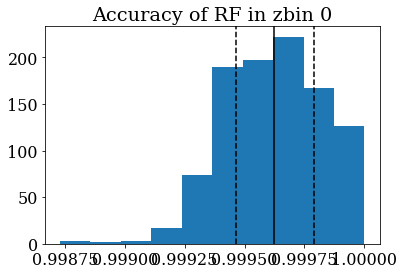

In [95]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist(test_acc_list)

mu  = np.mean(test_acc_list)
upper = np.percentile(test_acc_list, 84)
lower = np.percentile(test_acc_list, 16)
print "mean:", mu
print "84th:", upper
print "16th:", lower

ax.axvline(mu, color='k', ls='-')
ax.axvline(lower, color='k', ls='--')
ax.axvline(upper, color='k', ls='--')
ax.set(title='Accuracy of RF in zbin %d' % testn)

In [96]:
# Calculate the confusion matrix for each zbin's predictions
cm_list = {}
for sn_dir in datatables.keys():
    cm_list[sn_dir] = [ConfusionMatrix(a, p) for (a, p) in zip(actuals[sn_dir], predictions[sn_dir])]


In [97]:
# Check the results, should match tests from above
cm_list['bright_atpeak'][23]

Predicted   0.0    Ia  __all__
Actual                        
0.0        4626     1     4627
Ia            3  4707     4710
__all__    4629  4708     9337

In [98]:
RF_stats = {'ACC': [],
            'TPR': [],
            'TNR': [],
            'FPR': [],
            'FNR': [],
            }

for sn_dir in fluxscaled_sne:
    
    acc_list = [cm.ACC for cm in cm_list[sn_dir]]
    acc_mean = np.mean(acc_list)
    RF_stats['ACC'].append([acc_mean, 
                              acc_mean - np.percentile(acc_list, 16),
                              np.percentile(acc_list, 84) - acc_mean])
    
    tpr_list = [cm.TPR for cm in cm_list[sn_dir]]
    tpr_mean = np.mean(tpr_list)
    RF_stats['TPR'].append([tpr_mean, 
                              tpr_mean - np.percentile(tpr_list, 16),
                              np.percentile(tpr_list, 84) - tpr_mean])
    
    tnr_list = [cm.TNR for cm in cm_list[sn_dir]]
    tnr_mean = np.mean(tnr_list),
    RF_stats['TNR'].append([tnr_mean, 
                              tnr_mean - np.percentile(tnr_list, 16),
                              np.percentile(tnr_list, 84) - tnr_mean])
    
    fpr_list = [cm.FPR for cm in cm_list[sn_dir]]
    fpr_mean = np.mean(fpr_list)
    RF_stats['FPR'].append([fpr_mean, 
                              fpr_mean - np.percentile(fpr_list, 16),
                              np.percentile(fpr_list, 84) - fpr_mean])
    
    fnr_list = [cm.FNR for cm in cm_list[sn_dir]]
    fnr_mean = np.mean(fnr_list)
    RF_stats['FNR'].append([np.mean(fnr_list), 
                              fnr_mean - np.percentile(fnr_list, 16),
                              np.percentile(fnr_list, 84) - fnr_mean])
    
for stat in RF_stats:
    RF_stats[stat] = np.asarray(RF_stats[stat])

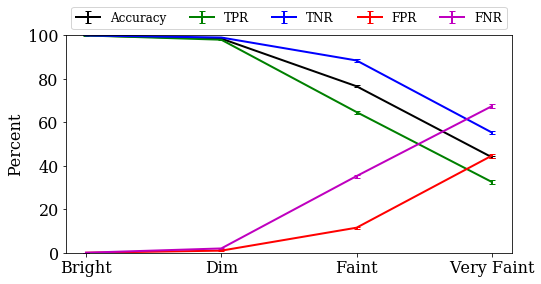

In [101]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

labels = ['Bright', 'Dim', 'Faint', 'Very Faint']

ax.errorbar(range(len(fluxscaled_sne)), RF_stats['ACC'][:,0]*100,
            yerr=[RF_stats['ACC'][:,1]*100, RF_stats['ACC'][:,2]*100],
            capsize=3, color='k', lw=2, label='Accuracy')

ax.errorbar(range(len(fluxscaled_sne)), RF_stats['TPR'][:,0]*100,
        yerr=[RF_stats['TPR'][:,1]*100, RF_stats['TPR'][:,2]*100],
            capsize=3, color='g', lw=2, label='TPR')

ax.errorbar(range(len(fluxscaled_sne)), RF_stats['TNR'][:,0]*100,
        yerr=[RF_stats['TNR'][:,1]*100, RF_stats['TNR'][:,2]*100],
            capsize=3, color='b', lw=2, label='TNR')

ax.errorbar(range(len(fluxscaled_sne)), RF_stats['FPR'][:,0]*100,
        yerr=[RF_stats['FPR'][:,1]*100, RF_stats['FPR'][:,2]*100],
            capsize=3, color='r', lw=2, label='FPR')

ax.errorbar(range(len(fluxscaled_sne)), RF_stats['FNR'][:,0]*100, 
        yerr=[RF_stats['FNR'][:,1]*100, RF_stats['FNR'][:,2]*100],
            capsize=3, color='m', lw=2, label='FNR')


# Lables and stuff
ax.set(ylabel='Percent', ylim=[0,100],
       xticks=range(len(fluxscaled_sne)), xticklabels=labels)

ax.legend(loc='center', bbox_to_anchor=(0.5, 1.08), ncol=5, fontsize=12)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

savedir = '/Users/ryanrubenzahl/Library/Ryan/College/Senior Thesis/'
savedir += 'thesis/Figures/'

# plt.savefig(savedir + 'residual_gaussianamplitude_ratioscaling_stats.png',
#            format='png', dpi=300, bbox_inches='tight')

In [102]:
for stat in RF_stats:
    print stat
    for i, sn_dir in enumerate(fluxscaled_sne):
        print "%s & $%.4f^{+%.4f}_{-%.4f}$" % (sn_dir, 
                                              RF_stats[stat][i][0]*100,
                                              RF_stats[stat][i][1]*100,
                                              RF_stats[stat][i][2]*100)

ACC
bright_atpeak & $99.9621^{+0.0156}_{-0.0169}$
dim_atpeak & $98.5013^{+0.1091}_{-0.1137}$
faint_atpeak & $76.5863^{+0.3831}_{-0.3870}$
very_faint_atpeak & $43.9536^{+0.5365}_{-0.5227}$
FPR
bright_atpeak & $0.0284^{+0.0284}_{-0.0151}$
dim_atpeak & $0.9946^{+0.1508}_{-0.1387}$
faint_atpeak & $11.5428^{+0.5053}_{-0.5134}$
very_faint_atpeak & $44.6625^{+0.8769}_{-0.8972}$
FNR
bright_atpeak & $0.0474^{+0.0265}_{-0.0368}$
dim_atpeak & $2.0028^{+0.2037}_{-0.1947}$
faint_atpeak & $35.2760^{+0.6565}_{-0.6662}$
very_faint_atpeak & $67.4202^{+0.8257}_{-0.8137}$
TPR
bright_atpeak & $99.9526^{+0.0368}_{-0.0265}$
dim_atpeak & $97.9972^{+0.1947}_{-0.2037}$
faint_atpeak & $64.7240^{+0.6662}_{-0.6565}$
very_faint_atpeak & $32.5798^{+0.8137}_{-0.8257}$
TNR
bright_atpeak & $99.9716^{+0.0151}_{-0.0284}$
dim_atpeak & $99.0054^{+0.1387}_{-0.1508}$
faint_atpeak & $88.4572^{+0.5134}_{-0.5053}$
very_faint_atpeak & $55.3375^{+0.8972}_{-0.8769}$


In [103]:
feature_importances = {}

for sn_dir in fluxscaled_sne:
    clfs = rf_classifiers[sn_dir]
    
    feature_scores = np.array([clf.feature_importances_ for clf in clfs])
    
    feature_importances[sn_dir] = [np.mean(feature_scores, axis=0),
                                   np.std(feature_scores, ddof=1, axis=0)]

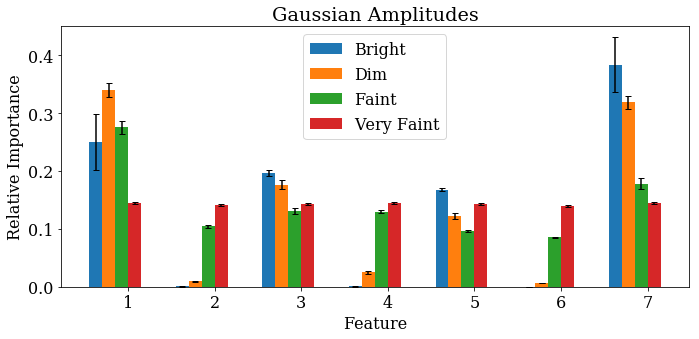

In [109]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

# Label line
labels = ['Bright', 'Dim', 'Faint', 'Very Faint']
width = 0.5
for i, sn_dir in enumerate(fluxscaled_sne):
    nfeatures = len(feature_importances[sn_dir][0])
    x = np.linspace(1, 3*nfeatures, nfeatures) + i*width
    ax.bar(x, feature_importances[sn_dir][0],
               yerr=feature_importances[sn_dir][1],
               width=width, align='edge',
               capsize=3, ecolor='k', label=labels[i])

ax.set(xlabel='Feature',
       ylabel='Relative Importance',
       xticks=x, xticklabels=range(1, nfeatures+1),
       ylim=[0, 0.45], title='Gaussian Amplitudes')
ax.legend(loc='upper center')
fig.tight_layout()

# plt.savefig(savedir + 'residual_gaussianamplitudes_feature_importances.png',
#             format='png', dpi=300, bbox_inches='tight')